In [1]:
# On essaye de réutiliser le code ~/openfisca_france_indirect_taxation/examples/benjello_candidates_to_removal/master_thesis/loosers_within_income_deciles.py
import numpy
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    graph_builder_bar)
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.projects.budgets.reforme_energie_budgets_2018_2019 import officielle_2019_in_2017
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy


In [2]:
ident_men = pd.DataFrame(pd.HDFStore("C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/data_collections/output/openfisca_indirect_taxation_data_2017.h5")['input']['ident_men'])
ident_men['ident_men'] = ident_men.ident_men.astype(numpy.int64)

data_path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data"
path = "C:/Users/veve1/OneDrive/Documents/ENSAE 3A/Memoire MiE/Data/donnees_simulations"
elasticite = True
replique_gouv = True

In [3]:
df_elasticities = pd.read_csv(os.path.join(data_path,'Elasticities_literature.csv'), sep = ";")
df_elasticities = df_elasticities.astype({'ref_elasticity': str, 'elas_price_1_1': float , 'elas_price_2_2' : float ,'elas_price_3_3' : float })

# exemple
#elasticites = df_elasticities[df_elasticities['ref_elasticity'] == 'Douenne (2020)'] 

In [4]:
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Simulation_taxe_energie_winners_losers import (
    simulate_reformes_energie,
    run_all_elasticities
    )
from openfisca_france_indirect_taxation.projects.Master_Thesis_Herve.Reform_carbon_tax import carbon_tax_rv

In [7]:
to_graph, menages_reform = run_all_elasticities(df_elasticities, year = 2018, reform = carbon_tax_rv)

c:\Users\veve1\OneDrive\Documents\ENSAE 3A\Memoire MiE\hervenv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


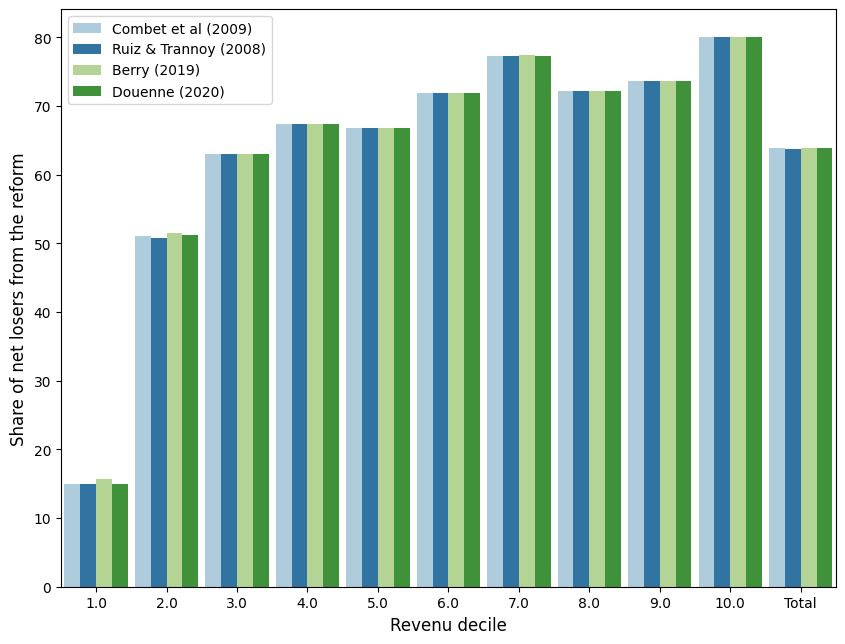

In [8]:
plt.figure(figsize= (10,7.5)) 
# Si on veut avoir la part de gagnants qui complète la bar jusqu'à 1 
#to_graph['total'] = 1
#bar1 = sns.barplot(x="niveau_vie_decile", y = 'total', data = to_graph, hue = 'ref_elasticity', palette = sns.color_palette("muted"), saturation = .2, width=.9)
bar2 = sns.barplot(x="niveau_vie_decile", y = 'losers', data = to_graph, hue = 'ref_elasticity', palette = sns.color_palette("Paired"), width = .9)
plt.xlabel('Revenu decile', fontdict = {'fontsize' : 12})
plt.ylabel('Share of net losers from the reform', fontdict = {'fontsize' : 12})
plt.legend()
plt.savefig(os.path.join(path,'Winners_losers_reform_carbon_tax_rv.png'))

In [10]:
menages_reform['ref_elasticity'] = 'Douenne (2020)'

<Axes: xlabel='niveau_vie_decile', ylabel='Net_apres_cheques_energie'>

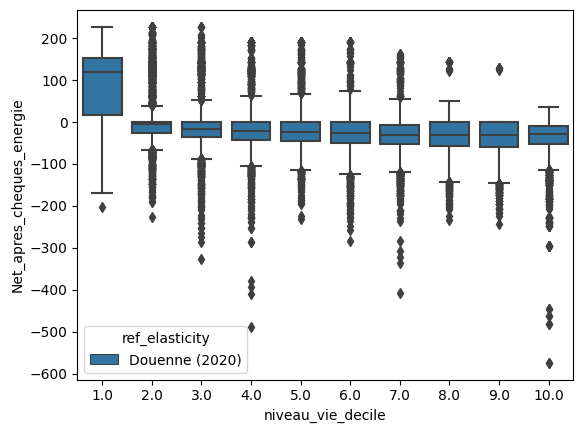

In [11]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "Net_apres_cheques_energie", hue = "ref_elasticity")

In [12]:
menages_reform['taux_effort'] = menages_reform['ticpe_totale_carbon_tax_rv'] / menages_reform['rev_disp_loyerimput'] * 100

<Axes: xlabel='niveau_vie_decile', ylabel='taux_effort'>

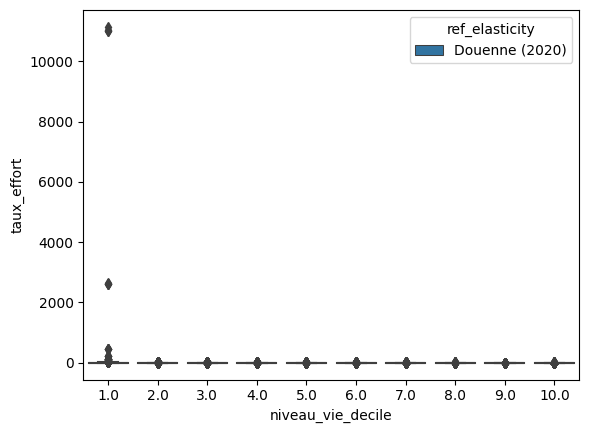

In [13]:
sns.boxplot(data = menages_reform, x = "niveau_vie_decile", y = "taux_effort", hue = "ref_elasticity")

In [14]:
menages_reform.columns

Index(['ocde10', 'ticpe_totale', 'niveau_vie_decile',
       'ticpe_totale_carbon_tax_rv', 'pondmen', 'ref_elasticity',
       'cheques_energie', 'rev_disp_loyerimput', 'Net_apres_cheques_energie',
       'is_losers', 'taux_effort'],
      dtype='object')

In [15]:
menages_reform.sort_values(by = 'taux_effort', ascending= False)

,ocde10,ticpe_totale,niveau_vie_decile,ticpe_totale_carbon_tax_rv,pondmen,ref_elasticity,cheques_energie,rev_disp_loyerimput,Net_apres_cheques_energie,is_losers,taux_effort
6623,1.0,297.350952,1.0,310.501526,2407,Douenne (2020),144.0,0.000000,130.849426,False,inf
10137,1.0,867.485291,1.0,910.349548,3180,Douenne (2020),144.0,0.000000,101.135742,False,inf
7583,1.0,242.398499,1.0,254.838776,6455,Douenne (2020),144.0,0.000000,131.559723,False,inf
4603,1.0,198.233994,1.0,207.001007,4467,Douenne (2020),144.0,0.000000,135.232986,False,inf
4603,1.0,198.233994,1.0,209.847610,4467,Douenne (2020),144.0,0.000000,132.386383,False,inf
...,...,...,...,...,...,...,...,...,...,...,...
12080,1.5,0.000000,3.0,0.000000,1407,Douenne (2020),0.0,30083.457031,0.000000,False,0.0
175,1.0,0.000000,1.0,0.000000,3901,Douenne (2020),144.0,0.000000,144.000000,False,NaN
175,1.0,0.000000,1.0,0.000000,3901,Douenne (2020),144.0,0.000000,144.000000,False,NaN
175,1.0,0.000000,1.0,0.000000,3901,Douenne (2020),144.0,0.000000,144.000000,False,NaN
